# **Credit Card Fraud Detection**
This Notebook aims to:
* Show how to deal with imbalanced data and which metrics could be useful
* Present the precision/recall trade-off 
* Predict whether a transaction is fraudulent or not <br>

The personal data of the clients has been transformed using PCA in order to protect sensitive information. <br>

**Plenty of things can still be done, including trying other models. If you have any suggestions or positive comments, please let me know.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline,FeatureUnion,make_pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import xgboost as xgb
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV,\
RepeatedKFold,RandomizedSearchCV,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,\
average_precision_score,roc_auc_score,recall_score,f1_score,jaccard_score,cohen_kappa_score,auc,precision_recall_curve,plot_precision_recall_curve,plot_roc_curve
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_pipe
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA


import warnings
warnings.simplefilter('ignore',DeprecationWarning)
warnings.simplefilter('ignore',FutureWarning)
pd.set_option("precision", 6)
sns.set_style('darkgrid')
%matplotlib inline

## **EDA**
Columns:
* Time: Number of seconds elapsed between this transaction and the first transaction in the dataset
* Class: 0 if normal transaction, 1 if fraud. I will change "Class" for "Fraud"
* V1 to V28: The 28 Principal Components obtained using PCA. This is done to protect sensitive information. 
* Amount: Transacion amount

In [2]:
df = pd.read_csv('creditcard.csv')
df.rename(columns={'Class':'Fraud'},inplace=True) # the change of name
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Fraud
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# some info about our columns
# all floats except for Fraud
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# no missing values
df.isnull().any().sum()

0

In [5]:
# Percentage of fraudulent transactions
print(f'Percentage of fraudulent transactions: {100*df.Fraud.mean():.6f}%')

Percentage of fraudulent transactions: 0.172749%


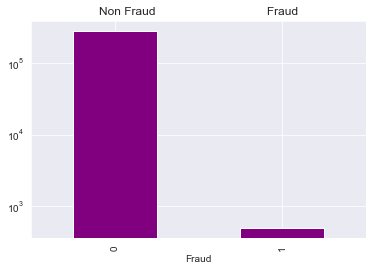

In [6]:
# The number of fraudulent transactions is very small
# The data is not balanced

df['Fraud'].value_counts().plot(kind='bar',color='purple')
plt.title('Non Fraud                                 Fraud')
plt.yscale('log') # for better visualization
plt.xlabel('Fraud')
plt.show()

### Some exploration

#### Time


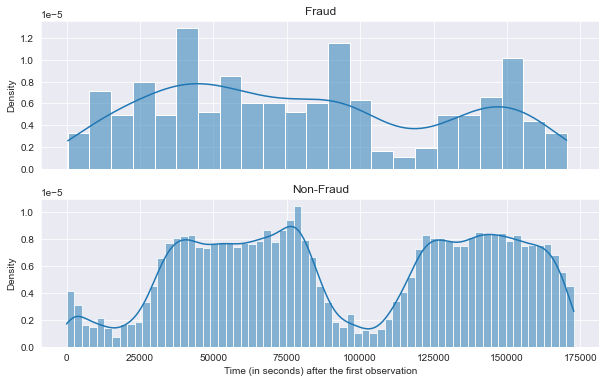

In [7]:
f,(ax1,ax2)  = plt.subplots(2,1,figsize=(10,6),sharex=True)

sns.histplot(df.loc[(df.Fraud==1),'Time'],kde=True,stat='density',ax=ax1,bins='sqrt') # sqrt of number of fraud operat
ax1.set_title('Fraud')
ax2.set_xlabel('Time (in seconds) after the first observation')
sns.histplot(df.loc[(df.Fraud==0),'Time'],kde=True,stat='density',ax=ax2)
ax2.set_title('Non-Fraud')
plt.show()

Fraud transactions seems to occur almost at every time of the day in the same way, while Non-Fraud transactions have some off-peak times. However, we do not know when the observation started, so we do not know the exact hour. 

#### Amount

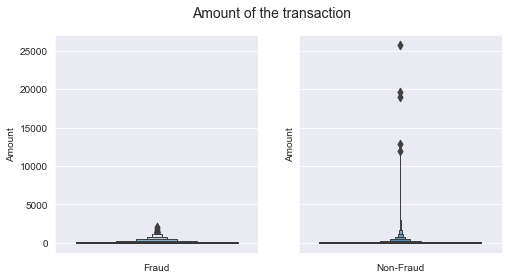

In [8]:
amount_fraud = df.loc[(df.Fraud==1),'Amount']
amount_n_fraud = df.loc[(df.Fraud==0),'Amount']
f,(ax1,ax2)  = plt.subplots(1,2,figsize=(8,4),sharey=True)
f.suptitle('Amount of the transaction',fontdict={'weight':'bold'},fontsize=14)
sns.boxenplot(y=amount_fraud,ax=ax1,orient='v')
ax1.set_xlabel('Fraud')
sns.boxenplot(y=amount_n_fraud,ax=ax2,orient='v')
ax2.set_xlabel('Non-Fraud')
plt.show()

Let's make a better analysis

In [9]:
# Fraud transactions analysis
IQR =np.percentile(amount_fraud,75)- np.percentile(amount_fraud,25) 
print(f'The IQR of Fraud transactions is {IQR:.6f}')
amount_fraud.describe()

The IQR of Fraud transactions is 104.890000


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
# Non-Fraud transactions analysis
IQR_nf =np.percentile(amount_n_fraud,75)- np.percentile(amount_n_fraud,25) 
print(f'The IQR of Non-Fraud transactions is {IQR_nf:.6f}')
amount_n_fraud.describe()

The IQR of Non-Fraud transactions is 71.400000


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

* Non-fraud transactions are less variable, but have some important outliers

In [11]:
# The mean absolute deviation is more robust to outliers

print('  Fraud MAD',' '*10,'Non-Fraud MAD')
amount_fraud.mad(),amount_n_fraud.mad()

  Fraud MAD            Non-Fraud MAD


(152.3787994910437, 103.44180860172067)

### Resampling 


In [12]:
# We split our data set, keeping the original distribution of Fruad by using stratify=y

X = df.loc[:,df.columns.difference(['Fraud'])]
y = df.Fraud
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.25)

In [13]:
# The same distribution
y_train.mean()

0.0017274876524425926

In [14]:
### We use smote to balance our training observations
# We combine undersampling(majority class) and oversampling(minority class)
# returns new X_train and y_train

def resampler(over, under, X_train, y_train):
    over = SMOTE(sampling_strategy = over, random_state = 0)
    under = RandomUnderSampler(sampling_strategy = under, random_state = 0)
    samp_pipe = imb_pipe([('over', over), ('under', under)])
    return samp_pipe.fit_resample(X_train, y_train)

In [15]:
# new training sets
# We want the minority class to be 0.2 of the data
# If we undersample too much we will lose too many information
# If we oversample too much we will be creating unrealistic samples

new_X_train, new_y_train = resampler(y_train.mean()*1.2, 1/4, X_train, y_train)

In [16]:
print('Fraud Distribution:',new_y_train.mean())
print('Number of Fraud and Non-Fraud:')
print(new_y_train.value_counts())

Fraud Distribution: 0.2
Number of Fraud and Non-Fraud:
0    1768
1     442
Name: Fraud, dtype: int64


### PCA and UMAP

In [17]:
# Principal components are always centered (mean=0), but in this case, 
# they don't have unit variance 
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Fraud
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [18]:
## PCA pipeline 
pre_pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

In [48]:
## umap
import umap
# We apply UMAP to scaled data
pre = Pipeline([('scaler',StandardScaler()),('umap',umap.UMAP())])

In [20]:
%%time 
#  Embedding of the resampled data
embedding = pre.fit_transform(new_X_train, new_y_train)

Wall time: 19.6 s


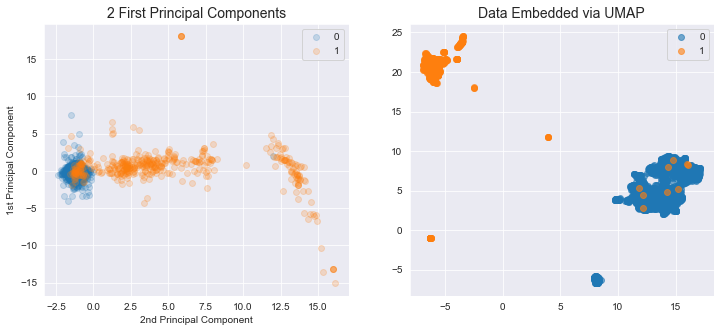

In [21]:
## We use PCA to see if our classes are separable
pca_plot = pre_pca.fit_transform(new_X_train).T  # data for the PCA plot

# We do the same with umap
emb_plot = embedding.T ## data for the UMAP plot

# We plot them
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2,1)
for i in [0,1]:
    ix = np.where(new_y_train==i)
    plt.scatter(*pca_plot[:,ix],label=i,cmap='Dark2',alpha = 0.2)
    plt.title('2 First Principal Components',fontsize=14)
    plt.ylabel('1st Principal Component')
    plt.xlabel('2nd Principal Component')
    plt.legend()
    
f.add_subplot(1,2,2)
for i in [0,1]:
    ix = np.where(new_y_train==i)
    plt.scatter(*emb_plot[:,ix],label=i,cmap='Dark2',alpha=0.6)
    plt.title('Data Embedded via UMAP',fontsize=14)
    plt.legend()

Classes are separable <br>
UMAP did a better job separating the classes <br>

### Correlation analysis


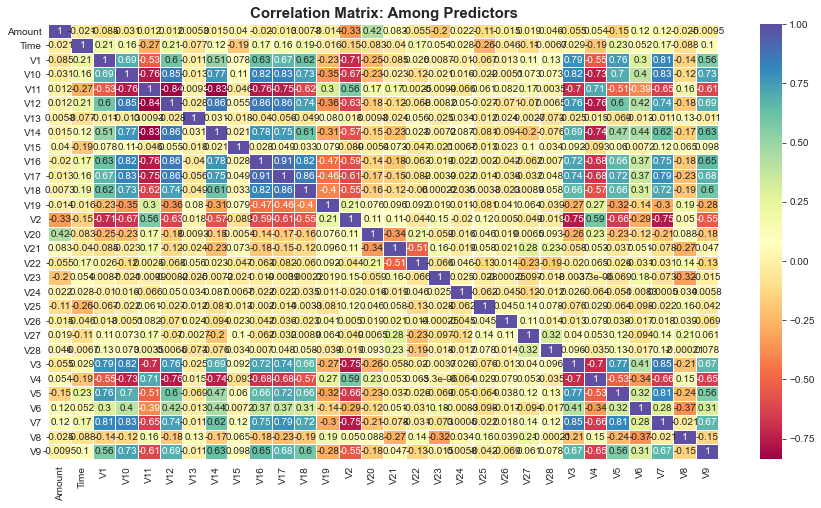

In [22]:
f = plt.figure(figsize=(15,8))
plt.title('Correlation Matrix: Among Predictors',fontsize=15,fontdict={'weight':'bold'})
sns.heatmap(new_X_train.corr(),linewidths=0.1,annot=True,cmap='Spectral')
plt.show()

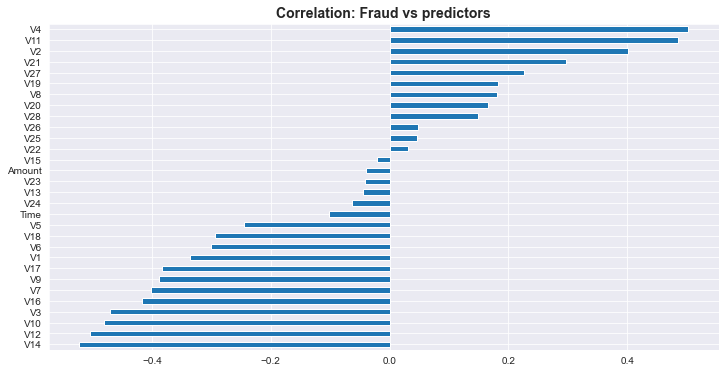

In [23]:
# Let's see how the predictors correlate with the response

f = plt.figure(figsize=(12,6))
plt.title('Correlation: Fraud vs predictors',fontsize=14,fontdict={'weight':'bold'})
new_X_train.corrwith(new_y_train,method='kendall').sort_values(ascending=True).plot(kind='barh')
plt.show()

In [24]:
# the "hihgly" correlated variables with the response
# abs(0.35) was chosen arbitrarily
highly_corr = new_X_train.corrwith(new_y_train,method='kendall')[abs(new_X_train.corrwith(new_y_train))>0.35].index
highly_corr

Index(['V1', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V2', 'V3', 'V4',
       'V5', 'V6', 'V7', 'V9'],
      dtype='object')

***
***
## **Modelling**

In [25]:
# Confusition matrix plot function
def conf_matrix_plot(y_test,y_pred):
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.7,fmt="d",cbar=False)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix',fontdict={'weight':'bold'},fontsize=14)
    plt.show()

In [26]:
# Complete classification report 
def complete_class_report(y_test, y_pred, y_score=None):
    print('---  Complete Classification Report  ---')
    print(classification_report(y_test,y_pred))
    # Other useful metrics
    print(f'Jaccard: {jaccard_score(y_test,y_pred)}')
    print(f"Cohen's kappa: {cohen_kappa_score(y_test,y_pred)}")
    # info of Precision-Recall and ROC curves
    if list(y_score)!=None:
        print(f'ROC_AUC: {roc_auc_score(y_test,y_score)}')
        print(f'Average Precision: {average_precision_score(y_test,y_score)}')
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        print(f'Area under Recall-Precision Curve: {auc(recall, precision)}')

* The Jaccard coefficient is a good metric if the data is imbalanced and we are more interested in the positive class. [Info](https://en.wikipedia.org/wiki/Jaccard_index)
* Cohen's kappa coefficient is a robust measure because takes into account the possibility of the agreement occurring by chance. [Info](https://en.wikipedia.org/wiki/Cohen%27s_kappa)


In [27]:
# precision-recall and ROC curve plots

def curves(clf,X_test,y_test,name=None):
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.set_title(f'Precision-Recall Curve')
    ax2.set_title(f'ROC Curve')
    plot_precision_recall_curve(clf,X_test,y_test,ax=ax1,c='goldenrod',name=name)
    plot_roc_curve(clf,X_test,y_test,ax=ax2,c='green',name=name)
    plt.show()

#### Random Forest fitted on original data
Random Forest is robust to outliers and features don't need to be scaled

In [28]:
### Random Forest fitted on original data
## I am not going to tune the hyperparameters because it takes too much time and the idea is to fit a model on the resampled data
clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200)

In [29]:
proba_pred = clf.predict_proba(X_test)[:,1] # probabilities

----------------------------------------

Threshold: 0.1


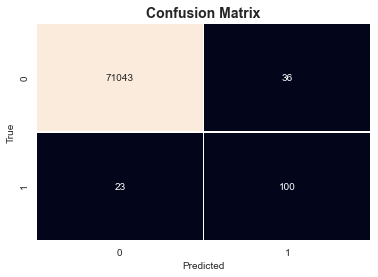

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.74      0.81      0.77       123

    accuracy                           1.00     71202
   macro avg       0.87      0.91      0.89     71202
weighted avg       1.00      1.00      1.00     71202

Jaccard: 0.6289308176100629
Cohen's kappa: 0.7717867506829419
ROC_AUC: 0.9482909603501978
Average Precision: 0.8212121835027669
Area under Recall-Precision Curve: 0.8261452641618386
----------------------------------------

Threshold: 0.2


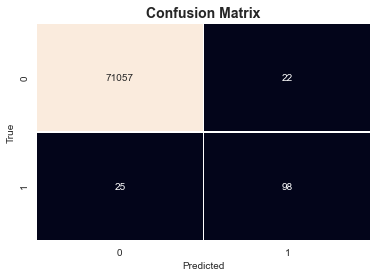

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.82      0.80      0.81       123

    accuracy                           1.00     71202
   macro avg       0.91      0.90      0.90     71202
weighted avg       1.00      1.00      1.00     71202

Jaccard: 0.6758620689655173
Cohen's kappa: 0.8062538015486523
ROC_AUC: 0.9482909603501978
Average Precision: 0.8212121835027669
Area under Recall-Precision Curve: 0.8261452641618386
----------------------------------------

Threshold: 0.3


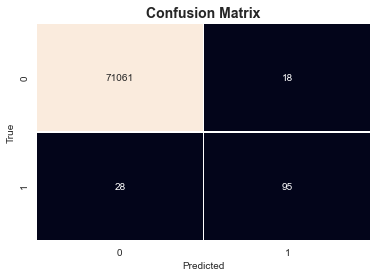

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.84      0.77      0.81       123

    accuracy                           1.00     71202
   macro avg       0.92      0.89      0.90     71202
weighted avg       1.00      1.00      1.00     71202

Jaccard: 0.6737588652482269
Cohen's kappa: 0.804761766808692
ROC_AUC: 0.9482909603501978
Average Precision: 0.8212121835027669
Area under Recall-Precision Curve: 0.8261452641618386
----------------------------------------

Threshold: 0.4


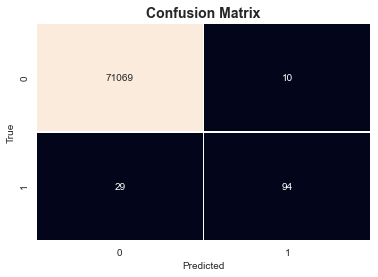

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.76      0.83       123

    accuracy                           1.00     71202
   macro avg       0.95      0.88      0.91     71202
weighted avg       1.00      1.00      1.00     71202

Jaccard: 0.706766917293233
Cohen's kappa: 0.8279214513979131
ROC_AUC: 0.9482909603501978
Average Precision: 0.8212121835027669
Area under Recall-Precision Curve: 0.8261452641618386
----------------------------------------

Threshold: 0.5


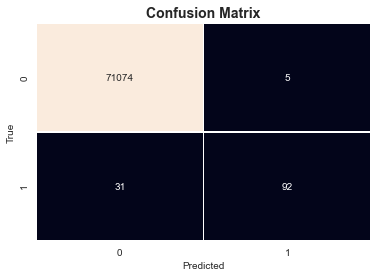

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.95      0.75      0.84       123

    accuracy                           1.00     71202
   macro avg       0.97      0.87      0.92     71202
weighted avg       1.00      1.00      1.00     71202

Jaccard: 0.71875
Cohen's kappa: 0.8361139850458212
ROC_AUC: 0.9482909603501978
Average Precision: 0.8212121835027669
Area under Recall-Precision Curve: 0.8261452641618386


In [30]:
# We try different probability thresholds to visualize the effect in recall and precision

for th in [0.1,0.2,0.3,0.4,0.5]:
    y_pred = (proba_pred>th).astype(int)
    print('-'*40)
    print(''*40)
    print('Threshold:',th)
    conf_matrix_plot(y_test,y_pred)
    complete_class_report(y_test,y_pred,proba_pred) # the last 3 metrics are already taking into consideration all thresholds

**Some comments**
* The area under the ROC curve give us an extremely optimistic score. 
* The recall is not good, but the precision is high

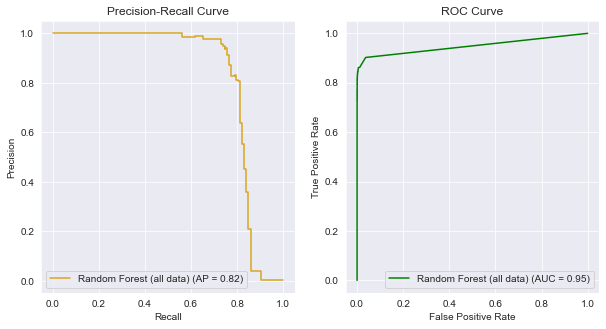

In [31]:
# We plot the roc curve and the precision-recall curve
curves(clf,X_test,y_test,name='Random Forest (all data)')

***
#### **Models with resampled data**
 We are going to use RandomForest model fitted on the resampled data

In [32]:
# models and scores for plotting later
models = []
classifiers = []

In [33]:
rf_params = {'n_estimators':[100,160,200,300,350],'max_depth':[None,5,10,20,50,60,80,100],'min_samples_split': [2, 5, 10]}
fold = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=0) # 5 folds and 3 repetitions
prueba = RandomizedSearchCV(RandomForestClassifier(),rf_params,cv=fold,scoring='jaccard',n_iter = 15).fit(new_X_train,new_y_train)

In [34]:
# probabilities
prueba_proba = prueba.predict_proba(X_test)[:,1]
# We save these for plotting
models.append('Random Forest')
classifiers.append(prueba)
prueba.best_params_ # The results of the randomized search

{'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 50}

----------------------------------------

Threshold: 0.1


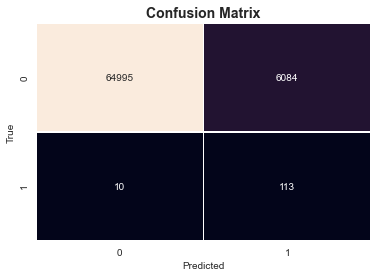

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.91      0.96     71079
           1       0.02      0.92      0.04       123

    accuracy                           0.91     71202
   macro avg       0.51      0.92      0.50     71202
weighted avg       1.00      0.91      0.95     71202

Jaccard: 0.018205252134686645
Cohen's kappa: 0.032481814289938016
ROC_AUC: 0.9785679326003575
Average Precision: 0.782706591501231
Area under Recall-Precision Curve: 0.7906837427560519
----------------------------------------

Threshold: 0.2


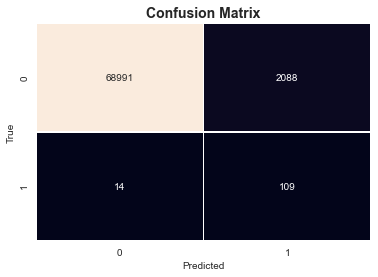

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71079
           1       0.05      0.89      0.09       123

    accuracy                           0.97     71202
   macro avg       0.52      0.93      0.54     71202
weighted avg       1.00      0.97      0.98     71202

Jaccard: 0.04929895974672094
Cohen's kappa: 0.09099143508287122
ROC_AUC: 0.9785679326003575
Average Precision: 0.782706591501231
Area under Recall-Precision Curve: 0.7906837427560519
----------------------------------------

Threshold: 0.3


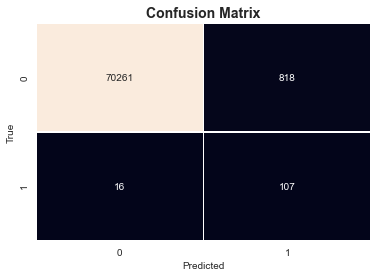

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71079
           1       0.12      0.87      0.20       123

    accuracy                           0.99     71202
   macro avg       0.56      0.93      0.60     71202
weighted avg       1.00      0.99      0.99     71202

Jaccard: 0.11370882040382571
Cohen's kappa: 0.20176428301987692
ROC_AUC: 0.9785679326003575
Average Precision: 0.782706591501231
Area under Recall-Precision Curve: 0.7906837427560519
----------------------------------------

Threshold: 0.4


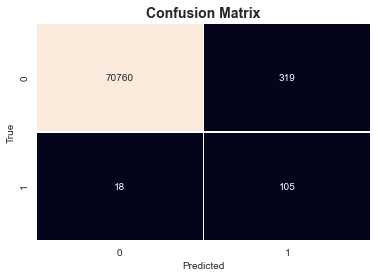

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.25      0.85      0.38       123

    accuracy                           1.00     71202
   macro avg       0.62      0.92      0.69     71202
weighted avg       1.00      1.00      1.00     71202

Jaccard: 0.23755656108597284
Cohen's kappa: 0.38225789385475284
ROC_AUC: 0.9785679326003575
Average Precision: 0.782706591501231
Area under Recall-Precision Curve: 0.7906837427560519
----------------------------------------

Threshold: 0.5


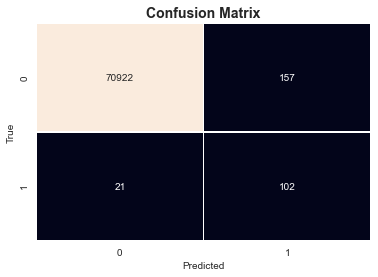

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.39      0.83      0.53       123

    accuracy                           1.00     71202
   macro avg       0.70      0.91      0.77     71202
weighted avg       1.00      1.00      1.00     71202

Jaccard: 0.36428571428571427
Cohen's kappa: 0.5329373200002211
ROC_AUC: 0.9785679326003575
Average Precision: 0.782706591501231
Area under Recall-Precision Curve: 0.7906837427560519


In [35]:
# We try different thresholds
for th in [0.1,0.2,0.3,0.4,0.5]:
    y_pred = (prueba_proba>th).astype(int)
    print('-'*40)
    print(''*40)
    print('Threshold:',th)
    conf_matrix_plot(y_test,y_pred),complete_class_report(y_test,y_pred,prueba_proba)

****
**Some comments**
* Like before, the ROC AUC is too optimistic.
* The recall improves using the resampled data, but the precision is very bad. The same happens by lowering the threshold.
* Jaccard and Cohen's Kappa coefficients are low because of the bad precision
* The companies want to increase the recall 


***
***
**Using Logistic Regression**

In [36]:
model = LogisticRegressionCV(max_iter=10000,scoring='jaccard',cv = fold)
pipe = Pipeline([('scaler',StandardScaler()),('model',model)])

In [37]:
%%time
# fitted on resampled data
pipe.fit(new_X_train,new_y_train)

Wall time: 5.2 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegressionCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0),
                                      max_iter=10000, scoring='jaccard'))])

In [38]:
# we estimate the probability of fraud
prob_lr =pipe.predict_proba(X_test)[:,1]
models.append('Logistic Regression')
classifiers.append(pipe)

----------------------------------------

Threshold: 0.1


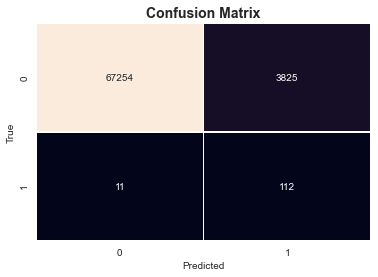

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     71079
           1       0.03      0.91      0.06       123

    accuracy                           0.95     71202
   macro avg       0.51      0.93      0.51     71202
weighted avg       1.00      0.95      0.97     71202

Jaccard: 0.028368794326241134
Cohen's kappa: 0.051996327340051884
ROC_AUC: 0.9741443077706851
Average Precision: 0.6858340384486992
Area under Recall-Precision Curve: 0.6850311129029928
----------------------------------------

Threshold: 0.2


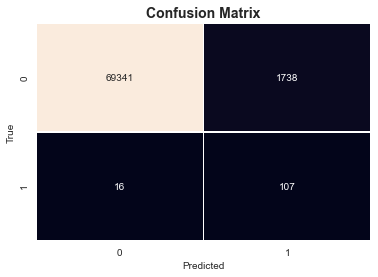

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71079
           1       0.06      0.87      0.11       123

    accuracy                           0.98     71202
   macro avg       0.53      0.92      0.55     71202
weighted avg       1.00      0.98      0.99     71202

Jaccard: 0.05749596990865126
Cohen's kappa: 0.10584364333421781
ROC_AUC: 0.9741443077706851
Average Precision: 0.6858340384486992
Area under Recall-Precision Curve: 0.6850311129029928
----------------------------------------

Threshold: 0.3


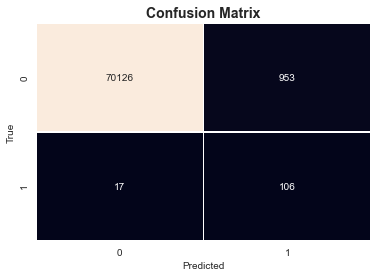

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71079
           1       0.10      0.86      0.18       123

    accuracy                           0.99     71202
   macro avg       0.55      0.92      0.59     71202
weighted avg       1.00      0.99      0.99     71202

Jaccard: 0.09851301115241635
Cohen's kappa: 0.1768088891272671
ROC_AUC: 0.9741443077706851
Average Precision: 0.6858340384486992
Area under Recall-Precision Curve: 0.6850311129029928
----------------------------------------

Threshold: 0.4


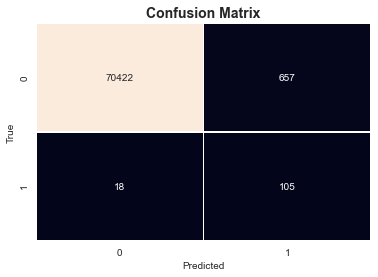

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71079
           1       0.14      0.85      0.24       123

    accuracy                           0.99     71202
   macro avg       0.57      0.92      0.62     71202
weighted avg       1.00      0.99      0.99     71202

Jaccard: 0.1346153846153846
Cohen's kappa: 0.23501246722750802
ROC_AUC: 0.9741443077706851
Average Precision: 0.6858340384486992
Area under Recall-Precision Curve: 0.6850311129029928
----------------------------------------

Threshold: 0.5


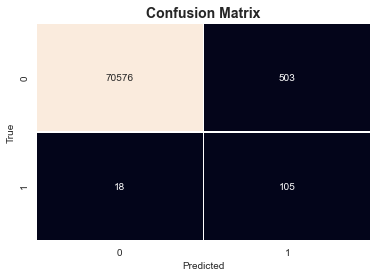

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71079
           1       0.17      0.85      0.29       123

    accuracy                           0.99     71202
   macro avg       0.59      0.92      0.64     71202
weighted avg       1.00      0.99      1.00     71202

Jaccard: 0.16773162939297126
Cohen's kappa: 0.28522370737338887
ROC_AUC: 0.9741443077706851
Average Precision: 0.6858340384486992
Area under Recall-Precision Curve: 0.6850311129029928


In [39]:
# We try different thresholds
for th in [0.1,0.2,0.3,0.4,0.5]:
    y_pred = (prob_lr>th).astype(int)
    print('-'*40)
    print(''*40)
    print('Threshold:',th)
    conf_matrix_plot(y_test,y_pred),complete_class_report(y_test,y_pred,prob_lr)

***
* Similar results to Random Forest
***

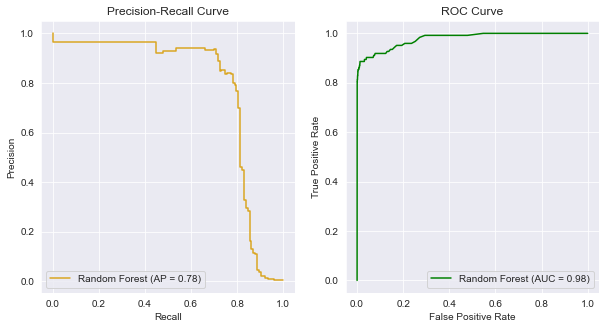

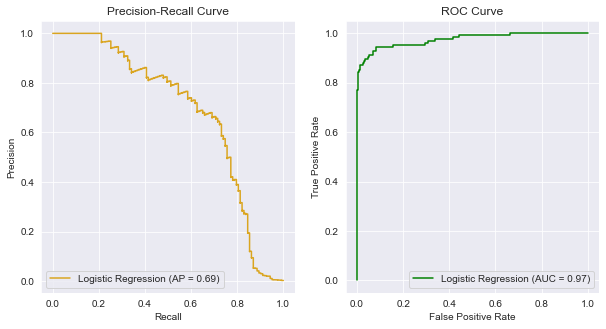

In [40]:
# We plot the ROC curve and the P-R curve
for mod,cl in zip(models,classifiers):
    curves(cl,X_test,y_test,name=mod)

* Random Forest is outperforming Logistic Regression  Average Precison. 

***
##### **Only using highly correlated variables** 
(Arbitraty)

In [41]:
# Logistic Regression
model = LogisticRegressionCV(max_iter=10000,scoring='jaccard',cv = fold)
pipe_hc = Pipeline([('scaler',StandardScaler()),('model',model)])
pipe_hc.fit(new_X_train[highly_corr],new_y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegressionCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0),
                                      max_iter=10000, scoring='jaccard'))])

In [42]:
h_c_prob = pipe_hc.predict_proba(X_test[highly_corr])[:,1]

----------------------------------------

Threshold: 0.1


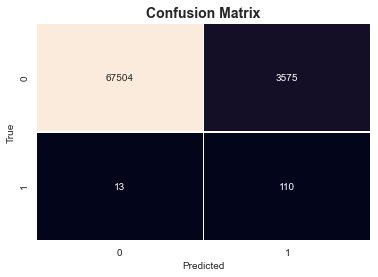

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     71079
           1       0.03      0.89      0.06       123

    accuracy                           0.95     71202
   macro avg       0.51      0.92      0.52     71202
weighted avg       1.00      0.95      0.97     71202

Jaccard: 0.029745808545159545
Cohen's kappa: 0.0546123355796585
ROC_AUC: 0.9641350623610486
Average Precision: 0.7441307810276699
Area under Recall-Precision Curve: 0.7435744322214798
----------------------------------------

Threshold: 0.2


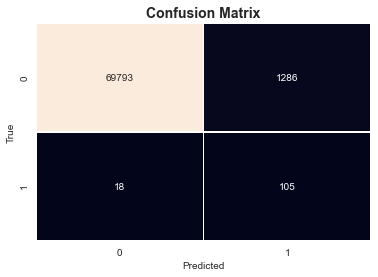

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71079
           1       0.08      0.85      0.14       123

    accuracy                           0.98     71202
   macro avg       0.54      0.92      0.56     71202
weighted avg       1.00      0.98      0.99     71202

Jaccard: 0.0745209368346345
Cohen's kappa: 0.13596272659695985
ROC_AUC: 0.9641350623610486
Average Precision: 0.7441307810276699
Area under Recall-Precision Curve: 0.7435744322214798
----------------------------------------

Threshold: 0.3


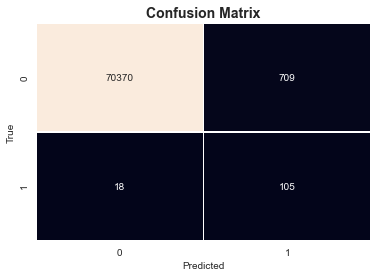

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71079
           1       0.13      0.85      0.22       123

    accuracy                           0.99     71202
   macro avg       0.56      0.92      0.61     71202
weighted avg       1.00      0.99      0.99     71202

Jaccard: 0.12620192307692307
Cohen's kappa: 0.2217837715209401
ROC_AUC: 0.9641350623610486
Average Precision: 0.7441307810276699
Area under Recall-Precision Curve: 0.7435744322214798
----------------------------------------

Threshold: 0.4


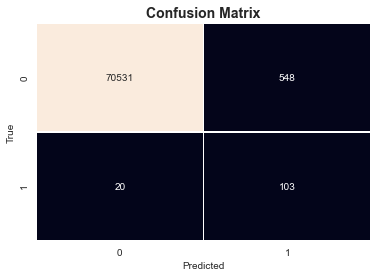

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71079
           1       0.16      0.84      0.27       123

    accuracy                           0.99     71202
   macro avg       0.58      0.91      0.63     71202
weighted avg       1.00      0.99      0.99     71202

Jaccard: 0.15350223546944858
Cohen's kappa: 0.26401114958594696
ROC_AUC: 0.9641350623610486
Average Precision: 0.7441307810276699
Area under Recall-Precision Curve: 0.7435744322214798
----------------------------------------

Threshold: 0.5


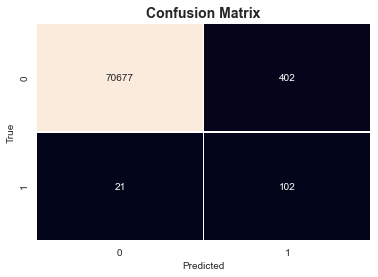

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71079
           1       0.20      0.83      0.33       123

    accuracy                           0.99     71202
   macro avg       0.60      0.91      0.66     71202
weighted avg       1.00      0.99      1.00     71202

Jaccard: 0.19428571428571428
Cohen's kappa: 0.3234800257953394
ROC_AUC: 0.9641350623610486
Average Precision: 0.7441307810276699
Area under Recall-Precision Curve: 0.7435744322214798


In [43]:
# We try different thresholds
for th in [0.1,0.2,0.3,0.4,0.5]:
    y_pred = (h_c_prob>th).astype(int)
    print('-'*40)
    print(''*40)
    print('Threshold:',th)
    conf_matrix_plot(y_test,y_pred),complete_class_report(y_test,y_pred,h_c_prob)

In [44]:
### With Random Forest
prueba2 = RandomizedSearchCV(RandomForestClassifier(),rf_params,
                       cv=fold,scoring='jaccard',n_iter=15).fit(new_X_train[highly_corr],new_y_train)

In [45]:
prueba2_proba = prueba2.predict_proba(X_test[highly_corr])[:,1]
prueba2.best_params_ # best params

{'n_estimators': 350, 'min_samples_split': 5, 'max_depth': 80}

----------------------------------------

Threshold: 0.1


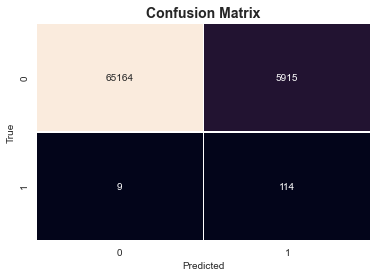

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     71079
           1       0.02      0.93      0.04       123

    accuracy                           0.92     71202
   macro avg       0.51      0.92      0.50     71202
weighted avg       1.00      0.92      0.95     71202

Jaccard: 0.01888042398145081
Cohen's kappa: 0.03378964368402115
ROC_AUC: 0.9700857868326289
Average Precision: 0.7457937767352745
Area under Recall-Precision Curve: 0.7632717451733633
----------------------------------------

Threshold: 0.2


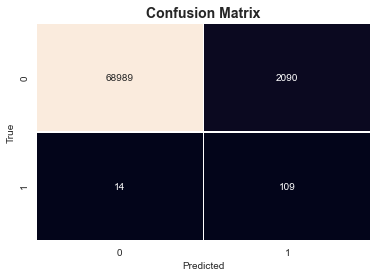

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71079
           1       0.05      0.89      0.09       123

    accuracy                           0.97     71202
   macro avg       0.52      0.93      0.54     71202
weighted avg       1.00      0.97      0.98     71202

Jaccard: 0.04925440578400361
Cohen's kappa: 0.09091009052789523
ROC_AUC: 0.9700857868326289
Average Precision: 0.7457937767352745
Area under Recall-Precision Curve: 0.7632717451733633
----------------------------------------

Threshold: 0.3


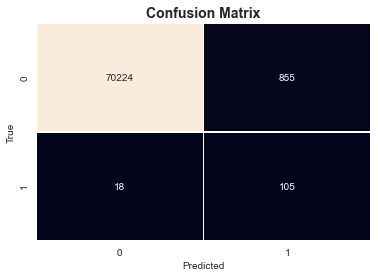

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71079
           1       0.11      0.85      0.19       123

    accuracy                           0.99     71202
   macro avg       0.55      0.92      0.59     71202
weighted avg       1.00      0.99      0.99     71202

Jaccard: 0.10736196319018405
Cohen's kappa: 0.19142951536538122
ROC_AUC: 0.9700857868326289
Average Precision: 0.7457937767352745
Area under Recall-Precision Curve: 0.7632717451733633
----------------------------------------

Threshold: 0.4


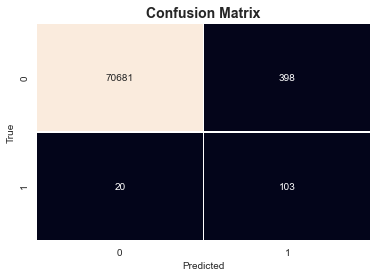

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71079
           1       0.21      0.84      0.33       123

    accuracy                           0.99     71202
   macro avg       0.60      0.92      0.66     71202
weighted avg       1.00      0.99      1.00     71202

Jaccard: 0.19769673704414586
Cohen's kappa: 0.3282648564886267
ROC_AUC: 0.9700857868326289
Average Precision: 0.7457937767352745
Area under Recall-Precision Curve: 0.7632717451733633
----------------------------------------

Threshold: 0.5


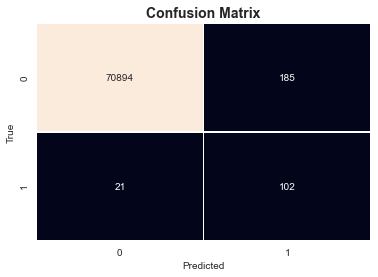

---  Complete Classification Report  ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.36      0.83      0.50       123

    accuracy                           1.00     71202
   macro avg       0.68      0.91      0.75     71202
weighted avg       1.00      1.00      1.00     71202

Jaccard: 0.33116883116883117
Cohen's kappa: 0.49634289531106457
ROC_AUC: 0.9700857868326289
Average Precision: 0.7457937767352745
Area under Recall-Precision Curve: 0.7632717451733633


In [46]:
# We try different thresholds
for th in [0.1,0.2,0.3,0.4,0.5]:
    y_pred = (prueba2_proba>th).astype(int)
    print('-'*40)
    print(''*40)
    print('Threshold:',th)
    conf_matrix_plot(y_test,y_pred),complete_class_report(y_test,y_pred,prueba2_proba)

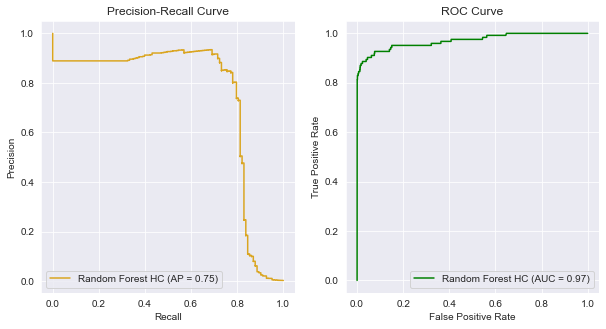

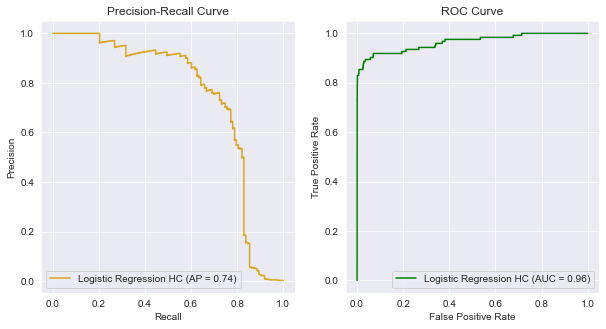

In [47]:
# Plot the ROC curve and P-R curve of the models that only used highly correlated features
models_hc = ['Random Forest HC','Logistic Regression HC']
classi_hc = [prueba2,pipe_hc]
for mod,clas in zip(models_hc,classi_hc):
    curves(clas,X_test[highly_corr],y_test,name=mod)

***
***
# **Conclusions**

* The area under the ROC curve is not a good metric if the data is imbalanced
* The precision-recall curve is a better option
* The area under the Precision-Recall curve is slightly more optimistic than the Average Precision. The latter is better because takes into consideration the increase in recall from the previous threshold used as the weight. [Example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py) 
* Training a model using imbalanced data results in high precision, but low recall
* Resampling increases the recall considerably, but the precision cost is very high
* By lowering the probability threshold the recall increases, but the precision decreases

**What should the credit card companies do?**
* The companies should prevent fraudulent transactions. Given that there is a trade-off between recall and precision, companies should calculate the economic, moral and reputational costs of:
    - Not being able to recognize fraudulent transactions.
    - Falsely accusing a transaction of being fraudulent and blocking the client's credit card.
* After knowing the impact of their decisions, companies will **set minimum values of both recall and precision.** 